In [1]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
from epam.shmple_precompute import load_and_convert_to_tensors
from netam.dnsm import DNSMBurrito, train_test_datasets_of_pcp_df
from netam.models import TransformerBinarySelectionModel
from epam.torch_common import pick_device
from epam.sequences import translate_sequences

device = pick_device()
if device.type == 'mps':
    print("Actually, using CPU")
    device = "cpu"

Using Metal Performance Shaders
Using Metal Performance Shaders
Actually, using CPU


In [2]:
pcp_df = load_and_convert_to_tensors("/Users/matsen/data/wyatt-10x-1p5m_pcp_2023-10-07.mimic-only_allow_mutations_at_hydrophobic_sites.shmple.hdf5")

# filter out rows of pcp_df where the parent and child sequences are identical
pcp_df = pcp_df[pcp_df["parent"] != pcp_df["child"]]

# NOTE downsampling here
pcp_df = pcp_df.sample(500, random_state=42)

print(f"We have {len(pcp_df)} PCPs.")

We have 500 PCPs.


In [3]:
train_dataset, val_dataset = train_test_datasets_of_pcp_df(
    pcp_df, branch_length_multiplier=5.0
)

consolidating shmple rates into substitution probabilities...
consolidating shmple rates into substitution probabilities...


In [4]:
def make_model_and_burrito():
    nhead = 2
    layer_count = 2
    dim_feedforward = 256
    d_model_per_head = 10
    dropout_prob = 0.1

    model = TransformerBinarySelectionModel(
        nhead=nhead, d_model_per_head=d_model_per_head, dim_feedforward=dim_feedforward, layer_count=layer_count, dropout_prob=dropout_prob,
    )

    burrito = DNSMBurrito(train_dataset, val_dataset, model, batch_size=1024, 
                        learning_rate=0.001, min_learning_rate=1e-6, l2_regularization_coeff=1e-6, 
                        device=device)

    return model, burrito

model, burrito = make_model_and_burrito()

In [5]:
def selection_factor_plot(model):
    parents = pcp_df.reset_index(drop=True)["parent"]
    if len(parents) > 1000:
        parents = parents.sample(1000)
    aa_parents = translate_sequences(parents)
    selection_factor_arrays = [model.selection_factors_of_aa_str(aa_str).cpu().numpy() for aa_str in aa_parents]

    hydrophobic_aas = set(list("AILMFWV"))
    # "control": random AAs
    # hydrophobic_aas = set(list("RKLFMTG"))

    def selection_factor_means(aa_str, selection_factor_array):
        hydrophobic_selection_factors = []
        other_selection_factors = []
        for aa, selection_factor in zip(aa_str, selection_factor_array):
            if aa in hydrophobic_aas:
                hydrophobic_selection_factors.append(selection_factor)
            else:
                other_selection_factors.append(selection_factor)
        return {"hydrophobic_selection_mean": np.mean(np.array(hydrophobic_selection_factors)),
                "other_selection_mean": np.mean(np.array(other_selection_factors))}

    df = pd.DataFrame([selection_factor_means(aa_str, selection_factor_array) for aa_str, selection_factor_array in zip(aa_parents, selection_factor_arrays)])

    # Scatter plot
    plt.scatter(df['hydrophobic_selection_mean'], df['other_selection_mean'], label='sequences', alpha=0.1)
    plt.xlabel('Hydrophobic Selection Mean')
    plt.ylabel('Other Selection Mean')

    # Add x=y line
    lims = [
        np.min([plt.xlim(), plt.ylim()]),  
        np.max([plt.xlim(), plt.ylim()]),  
    ]
    plt.plot(lims, lims, 'k--', alpha=0.5, label='x=y line')
    plt.xlim(lims)
    plt.ylim(lims)

    plt.legend()
    plt.show()

    return df


In [6]:
burrito.joint_train(epochs=100)

Finding optimal branch lengths:  14%|█▎        | 54/400 [00:01<00:07, 46.81it/s]/Users/matsen/mambaforge/envs/epam/lib/python3.9/site-packages/torch/nn/modules/transformer.py:380: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/NestedTensorImpl.cpp:180.)
  output = torch._nested_tensor_from_mask(output, src_key_padding_mask.logical_not(), mask_check=False)
Finding optimal branch lengths: 100%|██████████| 400/400 [00:08<00:00, 48.76it/s]


consolidating shmple rates into substitution probabilities...


Finding optimal branch lengths: 100%|██████████| 100/100 [00:01<00:00, 52.60it/s]


consolidating shmple rates into substitution probabilities...
consolidating shmple rates into substitution probabilities...
consolidating shmple rates into substitution probabilities...


Finding optimal branch lengths: 100%|██████████| 400/400 [00:06<00:00, 61.28it/s]


consolidating shmple rates into substitution probabilities...


Finding optimal branch lengths: 100%|██████████| 100/100 [00:01<00:00, 64.49it/s]


consolidating shmple rates into substitution probabilities...


Epoch: 100%|██████████| 100/100 [01:04<00:00,  1.54it/s, loss_diff=-1.107e-05, lr=0.0002, val_loss=0.1236]


,train_loss,val_loss
0,0.178040,0.186223
1,0.177731,0.181239
2,0.173540,0.176819
3,0.169824,0.173046
4,0.239736,0.243179
...,...,...
201,0.121127,0.123648
202,0.121442,0.123636
203,0.121162,0.123625
204,0.121173,0.123614


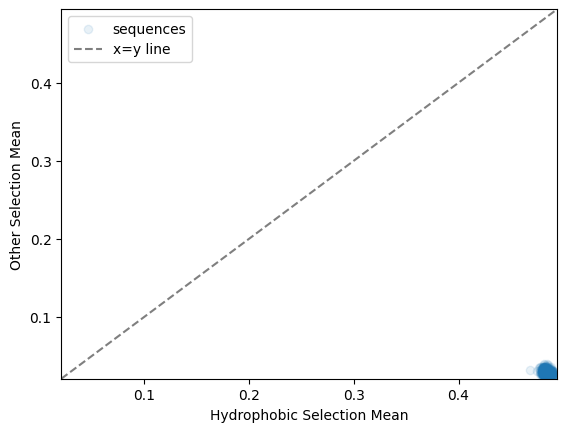

,hydrophobic_selection_mean,other_selection_mean
0,0.484569,0.030382
1,0.482271,0.035130
2,0.485198,0.030371
3,0.484246,0.032965
4,0.479975,0.034290
...,...,...
495,0.482024,0.030431
496,0.485088,0.030244
497,0.479710,0.030525
498,0.485661,0.029568


In [7]:
selection_df = selection_factor_plot(burrito.model)
selection_df

In [8]:
[aa_str] = translate_sequences([pcp_df.reset_index(drop=True).loc[0, "parent"]])
burrito.model.selection_factors_of_aa_str(aa_str)

tensor([0.0220, 0.5064, 0.0220, 0.4391, 0.5062, 0.0220, 0.0217, 0.0218, 0.0217,
        0.0218, 0.4411, 0.0217, 0.0218, 0.0219, 0.0218, 0.4865, 0.0217, 0.5064,
        0.0217, 0.5078, 0.0217, 0.0221, 0.0217, 0.4896, 0.0217, 0.0218, 0.0217,
        0.0217, 0.4795, 0.0217, 0.1644, 0.0217, 0.0218, 0.4462, 0.1065, 0.4718,
        0.5071, 0.0219, 0.0220, 0.4888, 0.0220, 0.0218, 0.0220, 0.0218, 0.4514,
        0.0218, 0.4704, 0.5042, 0.0218, 0.4749, 0.5105, 0.1377, 0.0217, 0.1200,
        0.0217, 0.0218, 0.2755, 0.0219, 0.0217, 0.0217, 0.4880, 0.0219, 0.0218,
        0.4843, 0.0217, 0.0218, 0.0218, 0.4821, 0.5071, 0.4856, 0.0217, 0.4465,
        0.0218, 0.0217, 0.0217, 0.5078, 0.0217, 0.0217, 0.4867, 0.0217, 0.4482,
        0.0220, 0.5103, 0.0217, 0.0217, 0.4444, 0.0217, 0.4910, 0.0218, 0.0218,
        0.0217, 0.4879, 0.5062, 0.0217, 0.0217, 0.0221, 0.4877, 0.0219, 0.0218,
        0.0219, 0.4913, 0.0217, 0.5079, 0.5053, 0.0219, 0.0218, 0.0219, 0.0218,
        0.4728, 0.4806, 0.0218, 0.0219, 

In [9]:
nobl_model, nobl_burrito = make_model_and_burrito()

nobl_burrito.train(epochs=200)

Epoch: 100%|██████████| 200/200 [02:11<00:00,  1.52it/s, loss_diff=-1.297e-05, lr=0.001, val_loss=0.1211]


,train_loss,val_loss
0,0.231171,0.238125
1,0.232373,0.227172
2,0.221863,0.218134
3,0.212911,0.211097
4,0.205796,0.205745
...,...,...
196,0.118547,0.121220
197,0.118556,0.121201
198,0.118668,0.121171
199,0.118743,0.121149


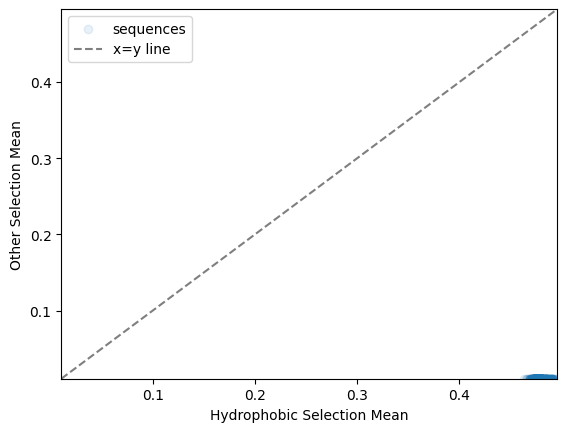

,hydrophobic_selection_mean,other_selection_mean
0,0.479048,0.010754
1,0.475023,0.010755
2,0.479585,0.010696
3,0.477147,0.010754
4,0.470462,0.010738
...,...,...
495,0.474880,0.010718
496,0.480484,0.010728
497,0.469223,0.010723
498,0.482423,0.010729


In [10]:
selection_factor_plot(nobl_burrito.model)